In [41]:
##################################
# Author : Baptiste PICARD       #
# Created the : 13/05/2021       #
# Last modifed : 24/06/2021      #
#                                #
# Volcanic eruptions prediction. #
##################################

# Here is the link to the competition
# https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/

# Imports
import os
import pip
import psutil
import random
import scipy
import subprocess
import numpy as np
import pandas as pd
import warnings
from pprint import pprint
from functools import wraps
from platform import python_version
from datetime import datetime as dt
from scipy.stats import norm, uniform
    
### Models
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import r2_score, roc_curve, auc, mean_squared_error, roc_auc_score
from sklearn.decomposition import PCA

### Vizualisation
import seaborn as sns
import matplotlib.pyplot as plt

try: 
    import kaggle
except ImportError:
    kaggle_config_file='./data/kaggle.json'
    kaggle_local_folder='C:/Users/picar/.kaggle'
    pip.main(['install', 'kaggle'])
    if not os.path.exists(os.path.join(kaggle_local_folder, kaggle_config_file.split('/')[-1])):
        if os.path.exists(kaggle_config_file):
            subprocess.check_output(["mv {kaggle_config_file} {kaggle_local_folder}".format( \
                                kaggle_config=kaggle_config_file, kaggle_local_folder=kaggle_local_folder)])
        else:
            raise FileNotFoundError('No such {kaggle_config_file}. You must download it on kaggle.com/account.' \
                                    .format(kaggle_config_file=kaggle_config_file))
    import kaggle
    print('Kaggle successfuly installed.')

# Versions
print("Python version : {}".format(python_version()))
print("Numpy version : {}".format(np.__version__))
print("Pandas version : {}".format(pd.__version__))

# Parameters 
PROJECT_PATH = 'D:\Projets\INGV'
data_train_folder = './data/train/'
data_test_folder = './data/test/'
data = './data/train.csv'
submissions = './data/sample_submission.csv'

# Environment 
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.width', 1000)
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")

Python version : 3.6.8
Numpy version : 1.18.1
Pandas version : 0.24.2


In [42]:
# Decorators
def time_execution(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = dt.now()
        result = f(*args, **kwargs)
        print('Function "{function_name}" tooks {duration} seconds to execute the function.' \
                          .format(function_name= f.__name__, duration=(dt.now()-start).seconds))
        return result
    return wrapper

def memory_usage(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        mem_before = psutil.Process(os.getpid()).memory_info().rss
        result = f(*args, **kwargs)
        mem_after = psutil.Process(os.getpid()).memory_info().rss
        cpu_usage = psutil.cpu_percent(interval=0.5)
        ram_usage =  psutil.virtual_memory().percent # int(psutil.virtual_memory().total - psutil.virtual_memory().available)
        print('''
                Function "{function_name}" consumed memory: {memory_consumption} MiB. 
                System CPU load is actually {cpu_usage} %. 
                RAM usage is {ram_usage} %.''' \
              .format(function_name=f.__name__, \
                      memory_consumption=(mem_after-mem_before)/1024*1024, \
                      cpu_usage=cpu_usage, ram_usage=ram_usage))
        return result
    return wrapper


# Functions
@memory_usage
@time_execution
def hello_world():
    return 'Hello World'

@memory_usage
@time_execution
def plot_df_time(dataframe):
    if isinstance(dataframe, pd.DataFrame):
        fig, axes = plt.subplots(ncols=1, nrows=len(dataframe.columns), figsize=(52,100))
        for i, ax in enumerate(axes.flatten()):
            sns.lineplot(x=dataframe.index, y=dataframe.columns[i], data=dataframe.fillna(0), ax=ax)
            ax.set_title(dataframe.columns[i])
    else:
        raise TypeError('Bad entry time')
        
@memory_usage
@time_execution
def plot_df_frequency(dataframe, frequency=100):
    if isinstance(dataframe, pd.DataFrame):
        fig, axes = plt.subplots(ncols=1, nrows=10, figsize=(52,100))
        for i, ax in enumerate(axes.flatten()):
            if dataframe.columns[i] in ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 
                           'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10']:
                FFT = abs(scipy.fft.fft(dataframe[dataframe.columns[i]]))
                ax.plot(FFT)
                ax.set_title(dataframe.columns[i])
    else:
        raise TypeError('Bad entry time')

def save_csv(df, filename, index=True, overwrite=False):
    if isinstance(df, pd.DataFrame) and isinstance(filename, str) and isinstance(index, bool):
        if filename[-3:]=='csv':
            if overwrite:
                try:
                    df.to_csv(filename, index=index)
                except Exception as exc:
                    raise exc
            else:
                raise ValueError('''File {filename} already exists. 
                                 You can setup the "overwrite" option on True to overwrite this file.''' \
                                 .format(filename=filename))
        else:
            raise ValueError('Bad filename format : {}.'.format(filename[:-3]))
    else:
        raise ValueError('Bad inputs')

def submit(file, message):
    if os.path.exists(file):
        try:
            cmd = 'kaggle competitions submit -c predict-volcanic-eruptions-ingv-oe -f {file} -m "{message}"' \
                            .format(file=file, message=message)
            return str(subprocess.check_output(cmd, shell=True))
        except Exception as exc:
            raise exc
    else: 
        raise FileNotFoundError('No such file : {}.'.format(file))
        
# Classes

# Test
hello_world()

Function "hello_world" tooks 0 seconds to execute the function.

                Function "hello_world" consumed memory: 0.0 MiB. 
                System CPU load is actually 23.3 %. 
                RAM usage is 83.2 %.


'Hello World'

In [43]:
# Load the main DataFrame with the time_to_eruption (to predict) 
train_df = pd.read_csv(data)
train_df_rows, train_df_col = train_df.shape
train_types = train_df.dtypes 

submissions_df = pd.read_csv(submissions)
submissions_df_rows, submissions_df_col = submissions_df.shape

print("Shape of main DataFrame is {} rows, {} cols.".format(train_df_rows, train_df_col))
print("Shape of submissions DataFrame is {} rows, {} cols.".format(submissions_df_rows, submissions_df_col))

# Updating main_df & submission_df time_to_eruption values
min_max_scaler = MinMaxScaler()
train_df.time_to_eruption = min_max_scaler.fit_transform(train_df.time_to_eruption.values.reshape(-1, 1))

# Heading
train_df.head(5) 

Shape of main DataFrame is 4431 rows, 2 cols.
Shape of submissions DataFrame is 4520 rows, 2 cols.


,segment_id,time_to_eruption
0,1136037770,0.249914
1,1969647810,0.667485
2,1895879680,0.305053
3,2068207140,0.539632
4,192955606,0.633489


In [44]:
train_df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # Apply helps changing scientific notation 

,segment_id,time_to_eruption
count,4431.00000,4431.00000
mean,1074694400.19567,0.46580
std,616196575.71450,0.27497
min,513181.00000,0.00000
25%,552793431.00000,0.22969
50%,1066152649.00000,0.45798
75%,1606349919.50000,0.70019
max,2146939378.00000,1.00000


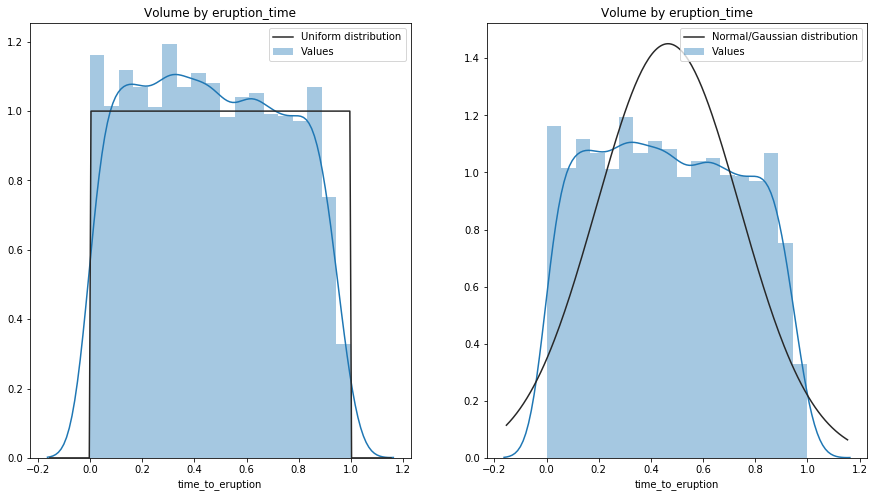

In [45]:
# Data do not fit normal distribution or Gaussian distribution | It is a continuous distribution. 
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title("Volume by eruption_time")
sns.distplot(train_df.time_to_eruption, fit=uniform)
plt.legend(["Uniform distribution", "Values"])
plt.subplot(122)
plt.title("Volume by eruption_time")
sns.distplot(train_df.time_to_eruption, fit=norm)
plt.legend(["Normal/Gaussian distribution", "Values"])

In [46]:
# Shaping the train DataFrame called 
all_files, sample = os.listdir(data_train_folder), ['1164158990.csv']
for d in range(5) :
    index = random.randrange(0, len(all_files))
    selected_file = all_files[index]
    if not selected_file in sample:
        sample.append(selected_file)
        
sample_df = pd.read_csv(os.path.join(data_train_folder, sample[0])) # item 1164158990
sample_df_rows, sample_df_columns = sample_df.shape
sample_df.fillna(0).describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,60001.000000,60001.0,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,-0.720571,-2.137398,0.0,-3.287645,-0.286829,20.543508,5.130031,7.626690,0.821836,-4.976634
std,514.941018,628.850195,0.0,333.404232,194.298806,2005.338927,525.461518,786.636085,386.515066,675.533292
min,-2195.000000,-12666.000000,0.0,-2346.000000,-3355.000000,-7791.000000,-2204.000000,-2843.000000,-2157.000000,-4014.000000
25%,-345.000000,-230.000000,0.0,-217.000000,-90.000000,-1322.000000,-344.000000,-546.000000,-251.000000,-396.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,336.000000,229.000000,0.0,210.000000,90.000000,1385.000000,347.000000,541.000000,250.000000,393.000000
max,2221.000000,14401.000000,0.0,2384.000000,5097.000000,6723.000000,1914.000000,3623.000000,1817.000000,4794.000000


In [47]:
# Preprocessing 
scaler = StandardScaler()
scaler.fit(sample_df.fillna(0))
scaler.mean_ # Get the mean values of each columns
standardized_df = pd.DataFrame(scaler.transform(sample_df.fillna(0)), columns=sample_df.columns)
standardized_df.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,6.000100e+04,6.000100e+04,60001.0,6.000100e+04,6.000100e+04,6.000100e+04,6.000100e+04,6.000100e+04,6.000100e+04,6.000100e+04
mean,-7.912058e-18,-3.139566e-18,0.0,2.168137e-18,1.105232e-17,-4.203419e-17,-3.708361e-17,-3.117824e-17,-4.072970e-17,-1.080183e-16
std,1.000008e+00,1.000008e+00,0.0,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-4.261260e+00,-2.013829e+01,0.0,-7.026701e+00,-1.726589e+01,-3.895406e+00,-4.204206e+00,-3.623849e+00,-5.582809e+00,-5.934655e+00
25%,-6.685859e-01,-3.623510e-01,0.0,-6.410061e-01,-4.617317e-01,-6.694902e-01,-6.644310e-01,-7.037960e-01,-6.515242e-01,-5.788414e-01
50%,1.399340e-03,3.398926e-03,0.0,9.860920e-03,1.476236e-03,-1.024449e-02,-9.762987e-03,-9.695402e-03,-2.126290e-03,7.367032e-03
75%,6.539067e-01,3.675586e-01,0.0,6.397322e-01,4.646842e-01,6.804176e-01,6.506144e-01,6.780489e-01,6.446844e-01,5.891345e-01
max,4.314551e+00,2.290412e+01,0.0,7.160400e+00,2.623449e+01,3.342334e+00,3.632780e+00,4.596031e+00,4.698894e+00,7.104042e+00


In [48]:
# Threading must be needed.
cols = ['segment_id', 'score_to_predict']
final_df = pd.DataFrame(columns=cols)

for index, segment in enumerate(train_df.segment_id):
    print("Train set - Step {}/{}.".format(index+1, train_df_rows))
    new_row = {
        'segment_id' : train_df.loc[train_df['segment_id']==segment].segment_id.item(),
        'score_to_predict' : train_df.loc[train_df['segment_id']==segment].time_to_eruption.item() 
    }
    if os.path.exists(os.path.join(data_train_folder, str(segment) + '.csv')):
        sample_df = pd.read_csv(os.path.join(data_train_folder, str(segment) + '.csv')).fillna(0)
        for col in sample_df.columns:
            new_row['mean_'+str(col)] = sample_df[col].mean()
            new_row['kurtosis_'+str(col)] = sample_df[col].kurtosis()
            new_row['skewness_'+str(col)] = sample_df[col].skew()
            new_row['max_'+str(col)] = sample_df[col].max()
            new_row['min_'+str(col)] = sample_df[col].min()
            new_row['delta_'+str(col)] = sample_df[col].max() - sample_df[col].min()
            new_row['var_'+str(col)] = sample_df[col].var()
            new_row['q02_'+str(col)] = np.quantile(sample_df[col], 0.02)
            new_row['q05_'+str(col)] = np.quantile(sample_df[col], 0.05)
            new_row['q25_'+str(col)] = np.quantile(sample_df[col], 0.25)
            new_row['q75_'+str(col)] = np.quantile(sample_df[col], 0.75)
            new_row['q95_'+str(col)] = np.quantile(sample_df[col], 0.95)
            new_row['q98_'+str(col)] = np.quantile(sample_df[col], 0.98)
        final_df = final_df.append(new_row, ignore_index=True)
    else:
        raise ValueError('No such {} segment_id'.format(segment))
        
for index, segment in enumerate(submissions_df.segment_id):
    print("Subimission set - Step {}/{}.".format(index+1, submissions_df_rows))
    new_row = {
        'segment_id' : submissions_df.loc[submissions_df['segment_id']==segment].segment_id.item(),
        'score_to_predict' : submissions_df.loc[submissions_df['segment_id']==segment].time_to_eruption.item() 
    }
    if os.path.exists(os.path.join(data_test_folder, str(segment) + '.csv')):
        sample_df = pd.read_csv(os.path.join(data_test_folder, str(segment) + '.csv')).fillna(0)
        for col in sample_df.columns:
            new_row['mean_'+str(col)] = sample_df[col].mean()
            new_row['kurtosis_'+str(col)] = sample_df[col].kurtosis()
            new_row['skewness_'+str(col)] = sample_df[col].skew()
            new_row['max_'+str(col)] = sample_df[col].max()
            new_row['min_'+str(col)] = sample_df[col].min()
            new_row['delta_'+str(col)] = sample_df[col].max() - sample_df[col].min()
            new_row['var_'+str(col)] = sample_df[col].var()
            new_row['q02_'+str(col)] = np.quantile(sample_df[col], 0.02)
            new_row['q05_'+str(col)] = np.quantile(sample_df[col], 0.05)
            new_row['q25_'+str(col)] = np.quantile(sample_df[col], 0.25)
            new_row['q75_'+str(col)] = np.quantile(sample_df[col], 0.75)
            new_row['q95_'+str(col)] = np.quantile(sample_df[col], 0.95)
            new_row['q98_'+str(col)] = np.quantile(sample_df[col], 0.98)
        final_df = final_df.append(new_row, ignore_index=True)
    else:
        raise ValueError('No such {} segment_id'.format(segment))

save_csv(final_df, 'data.csv', overwrite=True)

Train set - Step 1/4431.
Train set - Step 2/4431.
Train set - Step 3/4431.
Train set - Step 4/4431.
Train set - Step 5/4431.
Train set - Step 6/4431.
Train set - Step 7/4431.
Train set - Step 8/4431.
Train set - Step 9/4431.
Train set - Step 10/4431.
Train set - Step 11/4431.
Train set - Step 12/4431.
Train set - Step 13/4431.
Train set - Step 14/4431.
Train set - Step 15/4431.
Train set - Step 16/4431.
Train set - Step 17/4431.
Train set - Step 18/4431.
Train set - Step 19/4431.
Train set - Step 20/4431.
Train set - Step 21/4431.
Train set - Step 22/4431.
Train set - Step 23/4431.
Train set - Step 24/4431.
Train set - Step 25/4431.
Train set - Step 26/4431.
Train set - Step 27/4431.
Train set - Step 28/4431.
Train set - Step 29/4431.
Train set - Step 30/4431.
Train set - Step 31/4431.
Train set - Step 32/4431.
Train set - Step 33/4431.
Train set - Step 34/4431.
Train set - Step 35/4431.
Train set - Step 36/4431.
Train set - Step 37/4431.
Train set - Step 38/4431.
Train set - Step 39/4

Train set - Step 309/4431.
Train set - Step 310/4431.
Train set - Step 311/4431.
Train set - Step 312/4431.
Train set - Step 313/4431.
Train set - Step 314/4431.
Train set - Step 315/4431.
Train set - Step 316/4431.
Train set - Step 317/4431.
Train set - Step 318/4431.
Train set - Step 319/4431.
Train set - Step 320/4431.
Train set - Step 321/4431.
Train set - Step 322/4431.
Train set - Step 323/4431.
Train set - Step 324/4431.
Train set - Step 325/4431.
Train set - Step 326/4431.
Train set - Step 327/4431.
Train set - Step 328/4431.
Train set - Step 329/4431.
Train set - Step 330/4431.
Train set - Step 331/4431.
Train set - Step 332/4431.
Train set - Step 333/4431.
Train set - Step 334/4431.
Train set - Step 335/4431.
Train set - Step 336/4431.
Train set - Step 337/4431.
Train set - Step 338/4431.
Train set - Step 339/4431.
Train set - Step 340/4431.
Train set - Step 341/4431.
Train set - Step 342/4431.
Train set - Step 343/4431.
Train set - Step 344/4431.
Train set - Step 345/4431.
T

Train set - Step 613/4431.
Train set - Step 614/4431.
Train set - Step 615/4431.
Train set - Step 616/4431.
Train set - Step 617/4431.
Train set - Step 618/4431.
Train set - Step 619/4431.
Train set - Step 620/4431.
Train set - Step 621/4431.
Train set - Step 622/4431.
Train set - Step 623/4431.
Train set - Step 624/4431.
Train set - Step 625/4431.
Train set - Step 626/4431.
Train set - Step 627/4431.
Train set - Step 628/4431.
Train set - Step 629/4431.
Train set - Step 630/4431.
Train set - Step 631/4431.
Train set - Step 632/4431.
Train set - Step 633/4431.
Train set - Step 634/4431.
Train set - Step 635/4431.
Train set - Step 636/4431.
Train set - Step 637/4431.
Train set - Step 638/4431.
Train set - Step 639/4431.
Train set - Step 640/4431.
Train set - Step 641/4431.
Train set - Step 642/4431.
Train set - Step 643/4431.
Train set - Step 644/4431.
Train set - Step 645/4431.
Train set - Step 646/4431.
Train set - Step 647/4431.
Train set - Step 648/4431.
Train set - Step 649/4431.
T

Train set - Step 917/4431.
Train set - Step 918/4431.
Train set - Step 919/4431.
Train set - Step 920/4431.
Train set - Step 921/4431.
Train set - Step 922/4431.
Train set - Step 923/4431.
Train set - Step 924/4431.
Train set - Step 925/4431.
Train set - Step 926/4431.
Train set - Step 927/4431.
Train set - Step 928/4431.
Train set - Step 929/4431.
Train set - Step 930/4431.
Train set - Step 931/4431.
Train set - Step 932/4431.
Train set - Step 933/4431.
Train set - Step 934/4431.
Train set - Step 935/4431.
Train set - Step 936/4431.
Train set - Step 937/4431.
Train set - Step 938/4431.
Train set - Step 939/4431.
Train set - Step 940/4431.
Train set - Step 941/4431.
Train set - Step 942/4431.
Train set - Step 943/4431.
Train set - Step 944/4431.
Train set - Step 945/4431.
Train set - Step 946/4431.
Train set - Step 947/4431.
Train set - Step 948/4431.
Train set - Step 949/4431.
Train set - Step 950/4431.
Train set - Step 951/4431.
Train set - Step 952/4431.
Train set - Step 953/4431.
T

Train set - Step 1214/4431.
Train set - Step 1215/4431.
Train set - Step 1216/4431.
Train set - Step 1217/4431.
Train set - Step 1218/4431.
Train set - Step 1219/4431.
Train set - Step 1220/4431.
Train set - Step 1221/4431.
Train set - Step 1222/4431.
Train set - Step 1223/4431.
Train set - Step 1224/4431.
Train set - Step 1225/4431.
Train set - Step 1226/4431.
Train set - Step 1227/4431.
Train set - Step 1228/4431.
Train set - Step 1229/4431.
Train set - Step 1230/4431.
Train set - Step 1231/4431.
Train set - Step 1232/4431.
Train set - Step 1233/4431.
Train set - Step 1234/4431.
Train set - Step 1235/4431.
Train set - Step 1236/4431.
Train set - Step 1237/4431.
Train set - Step 1238/4431.
Train set - Step 1239/4431.
Train set - Step 1240/4431.
Train set - Step 1241/4431.
Train set - Step 1242/4431.
Train set - Step 1243/4431.
Train set - Step 1244/4431.
Train set - Step 1245/4431.
Train set - Step 1246/4431.
Train set - Step 1247/4431.
Train set - Step 1248/4431.
Train set - Step 124

Train set - Step 1507/4431.
Train set - Step 1508/4431.
Train set - Step 1509/4431.
Train set - Step 1510/4431.
Train set - Step 1511/4431.
Train set - Step 1512/4431.
Train set - Step 1513/4431.
Train set - Step 1514/4431.
Train set - Step 1515/4431.
Train set - Step 1516/4431.
Train set - Step 1517/4431.
Train set - Step 1518/4431.
Train set - Step 1519/4431.
Train set - Step 1520/4431.
Train set - Step 1521/4431.
Train set - Step 1522/4431.
Train set - Step 1523/4431.
Train set - Step 1524/4431.
Train set - Step 1525/4431.
Train set - Step 1526/4431.
Train set - Step 1527/4431.
Train set - Step 1528/4431.
Train set - Step 1529/4431.
Train set - Step 1530/4431.
Train set - Step 1531/4431.
Train set - Step 1532/4431.
Train set - Step 1533/4431.
Train set - Step 1534/4431.
Train set - Step 1535/4431.
Train set - Step 1536/4431.
Train set - Step 1537/4431.
Train set - Step 1538/4431.
Train set - Step 1539/4431.
Train set - Step 1540/4431.
Train set - Step 1541/4431.
Train set - Step 154

Train set - Step 1800/4431.
Train set - Step 1801/4431.
Train set - Step 1802/4431.
Train set - Step 1803/4431.
Train set - Step 1804/4431.
Train set - Step 1805/4431.
Train set - Step 1806/4431.
Train set - Step 1807/4431.
Train set - Step 1808/4431.
Train set - Step 1809/4431.
Train set - Step 1810/4431.
Train set - Step 1811/4431.
Train set - Step 1812/4431.
Train set - Step 1813/4431.
Train set - Step 1814/4431.
Train set - Step 1815/4431.
Train set - Step 1816/4431.
Train set - Step 1817/4431.
Train set - Step 1818/4431.
Train set - Step 1819/4431.
Train set - Step 1820/4431.
Train set - Step 1821/4431.
Train set - Step 1822/4431.
Train set - Step 1823/4431.
Train set - Step 1824/4431.
Train set - Step 1825/4431.
Train set - Step 1826/4431.
Train set - Step 1827/4431.
Train set - Step 1828/4431.
Train set - Step 1829/4431.
Train set - Step 1830/4431.
Train set - Step 1831/4431.
Train set - Step 1832/4431.
Train set - Step 1833/4431.
Train set - Step 1834/4431.
Train set - Step 183

Train set - Step 2094/4431.
Train set - Step 2095/4431.
Train set - Step 2096/4431.
Train set - Step 2097/4431.
Train set - Step 2098/4431.
Train set - Step 2099/4431.
Train set - Step 2100/4431.
Train set - Step 2101/4431.
Train set - Step 2102/4431.
Train set - Step 2103/4431.
Train set - Step 2104/4431.
Train set - Step 2105/4431.
Train set - Step 2106/4431.
Train set - Step 2107/4431.
Train set - Step 2108/4431.
Train set - Step 2109/4431.
Train set - Step 2110/4431.
Train set - Step 2111/4431.
Train set - Step 2112/4431.
Train set - Step 2113/4431.
Train set - Step 2114/4431.
Train set - Step 2115/4431.
Train set - Step 2116/4431.
Train set - Step 2117/4431.
Train set - Step 2118/4431.
Train set - Step 2119/4431.
Train set - Step 2120/4431.
Train set - Step 2121/4431.
Train set - Step 2122/4431.
Train set - Step 2123/4431.
Train set - Step 2124/4431.
Train set - Step 2125/4431.
Train set - Step 2126/4431.
Train set - Step 2127/4431.
Train set - Step 2128/4431.
Train set - Step 212

Train set - Step 2387/4431.
Train set - Step 2388/4431.
Train set - Step 2389/4431.
Train set - Step 2390/4431.
Train set - Step 2391/4431.
Train set - Step 2392/4431.
Train set - Step 2393/4431.
Train set - Step 2394/4431.
Train set - Step 2395/4431.
Train set - Step 2396/4431.
Train set - Step 2397/4431.
Train set - Step 2398/4431.
Train set - Step 2399/4431.
Train set - Step 2400/4431.
Train set - Step 2401/4431.
Train set - Step 2402/4431.
Train set - Step 2403/4431.
Train set - Step 2404/4431.
Train set - Step 2405/4431.
Train set - Step 2406/4431.
Train set - Step 2407/4431.
Train set - Step 2408/4431.
Train set - Step 2409/4431.
Train set - Step 2410/4431.
Train set - Step 2411/4431.
Train set - Step 2412/4431.
Train set - Step 2413/4431.
Train set - Step 2414/4431.
Train set - Step 2415/4431.
Train set - Step 2416/4431.
Train set - Step 2417/4431.
Train set - Step 2418/4431.
Train set - Step 2419/4431.
Train set - Step 2420/4431.
Train set - Step 2421/4431.
Train set - Step 242

Train set - Step 2680/4431.
Train set - Step 2681/4431.
Train set - Step 2682/4431.
Train set - Step 2683/4431.
Train set - Step 2684/4431.
Train set - Step 2685/4431.
Train set - Step 2686/4431.
Train set - Step 2687/4431.
Train set - Step 2688/4431.
Train set - Step 2689/4431.
Train set - Step 2690/4431.
Train set - Step 2691/4431.
Train set - Step 2692/4431.
Train set - Step 2693/4431.
Train set - Step 2694/4431.
Train set - Step 2695/4431.
Train set - Step 2696/4431.
Train set - Step 2697/4431.
Train set - Step 2698/4431.
Train set - Step 2699/4431.
Train set - Step 2700/4431.
Train set - Step 2701/4431.
Train set - Step 2702/4431.
Train set - Step 2703/4431.
Train set - Step 2704/4431.
Train set - Step 2705/4431.
Train set - Step 2706/4431.
Train set - Step 2707/4431.
Train set - Step 2708/4431.
Train set - Step 2709/4431.
Train set - Step 2710/4431.
Train set - Step 2711/4431.
Train set - Step 2712/4431.
Train set - Step 2713/4431.
Train set - Step 2714/4431.
Train set - Step 271

Train set - Step 2974/4431.
Train set - Step 2975/4431.
Train set - Step 2976/4431.
Train set - Step 2977/4431.
Train set - Step 2978/4431.
Train set - Step 2979/4431.
Train set - Step 2980/4431.
Train set - Step 2981/4431.
Train set - Step 2982/4431.
Train set - Step 2983/4431.
Train set - Step 2984/4431.
Train set - Step 2985/4431.
Train set - Step 2986/4431.
Train set - Step 2987/4431.
Train set - Step 2988/4431.
Train set - Step 2989/4431.
Train set - Step 2990/4431.
Train set - Step 2991/4431.
Train set - Step 2992/4431.
Train set - Step 2993/4431.
Train set - Step 2994/4431.
Train set - Step 2995/4431.
Train set - Step 2996/4431.
Train set - Step 2997/4431.
Train set - Step 2998/4431.
Train set - Step 2999/4431.
Train set - Step 3000/4431.
Train set - Step 3001/4431.
Train set - Step 3002/4431.
Train set - Step 3003/4431.
Train set - Step 3004/4431.
Train set - Step 3005/4431.
Train set - Step 3006/4431.
Train set - Step 3007/4431.
Train set - Step 3008/4431.
Train set - Step 300

Train set - Step 3267/4431.
Train set - Step 3268/4431.
Train set - Step 3269/4431.
Train set - Step 3270/4431.
Train set - Step 3271/4431.
Train set - Step 3272/4431.
Train set - Step 3273/4431.
Train set - Step 3274/4431.
Train set - Step 3275/4431.
Train set - Step 3276/4431.
Train set - Step 3277/4431.
Train set - Step 3278/4431.
Train set - Step 3279/4431.
Train set - Step 3280/4431.
Train set - Step 3281/4431.
Train set - Step 3282/4431.
Train set - Step 3283/4431.
Train set - Step 3284/4431.
Train set - Step 3285/4431.
Train set - Step 3286/4431.
Train set - Step 3287/4431.
Train set - Step 3288/4431.
Train set - Step 3289/4431.
Train set - Step 3290/4431.
Train set - Step 3291/4431.
Train set - Step 3292/4431.
Train set - Step 3293/4431.
Train set - Step 3294/4431.
Train set - Step 3295/4431.
Train set - Step 3296/4431.
Train set - Step 3297/4431.
Train set - Step 3298/4431.
Train set - Step 3299/4431.
Train set - Step 3300/4431.
Train set - Step 3301/4431.
Train set - Step 330

Train set - Step 3560/4431.
Train set - Step 3561/4431.
Train set - Step 3562/4431.
Train set - Step 3563/4431.
Train set - Step 3564/4431.
Train set - Step 3565/4431.
Train set - Step 3566/4431.
Train set - Step 3567/4431.
Train set - Step 3568/4431.
Train set - Step 3569/4431.
Train set - Step 3570/4431.
Train set - Step 3571/4431.
Train set - Step 3572/4431.
Train set - Step 3573/4431.
Train set - Step 3574/4431.
Train set - Step 3575/4431.
Train set - Step 3576/4431.
Train set - Step 3577/4431.
Train set - Step 3578/4431.
Train set - Step 3579/4431.
Train set - Step 3580/4431.
Train set - Step 3581/4431.
Train set - Step 3582/4431.
Train set - Step 3583/4431.
Train set - Step 3584/4431.
Train set - Step 3585/4431.
Train set - Step 3586/4431.
Train set - Step 3587/4431.
Train set - Step 3588/4431.
Train set - Step 3589/4431.
Train set - Step 3590/4431.
Train set - Step 3591/4431.
Train set - Step 3592/4431.
Train set - Step 3593/4431.
Train set - Step 3594/4431.
Train set - Step 359

Train set - Step 3854/4431.
Train set - Step 3855/4431.
Train set - Step 3856/4431.
Train set - Step 3857/4431.
Train set - Step 3858/4431.
Train set - Step 3859/4431.
Train set - Step 3860/4431.
Train set - Step 3861/4431.
Train set - Step 3862/4431.
Train set - Step 3863/4431.
Train set - Step 3864/4431.
Train set - Step 3865/4431.
Train set - Step 3866/4431.
Train set - Step 3867/4431.
Train set - Step 3868/4431.
Train set - Step 3869/4431.
Train set - Step 3870/4431.
Train set - Step 3871/4431.
Train set - Step 3872/4431.
Train set - Step 3873/4431.
Train set - Step 3874/4431.
Train set - Step 3875/4431.
Train set - Step 3876/4431.
Train set - Step 3877/4431.
Train set - Step 3878/4431.
Train set - Step 3879/4431.
Train set - Step 3880/4431.
Train set - Step 3881/4431.
Train set - Step 3882/4431.
Train set - Step 3883/4431.
Train set - Step 3884/4431.
Train set - Step 3885/4431.
Train set - Step 3886/4431.
Train set - Step 3887/4431.
Train set - Step 3888/4431.
Train set - Step 388

Train set - Step 4147/4431.
Train set - Step 4148/4431.
Train set - Step 4149/4431.
Train set - Step 4150/4431.
Train set - Step 4151/4431.
Train set - Step 4152/4431.
Train set - Step 4153/4431.
Train set - Step 4154/4431.
Train set - Step 4155/4431.
Train set - Step 4156/4431.
Train set - Step 4157/4431.
Train set - Step 4158/4431.
Train set - Step 4159/4431.
Train set - Step 4160/4431.
Train set - Step 4161/4431.
Train set - Step 4162/4431.
Train set - Step 4163/4431.
Train set - Step 4164/4431.
Train set - Step 4165/4431.
Train set - Step 4166/4431.
Train set - Step 4167/4431.
Train set - Step 4168/4431.
Train set - Step 4169/4431.
Train set - Step 4170/4431.
Train set - Step 4171/4431.
Train set - Step 4172/4431.
Train set - Step 4173/4431.
Train set - Step 4174/4431.
Train set - Step 4175/4431.
Train set - Step 4176/4431.
Train set - Step 4177/4431.
Train set - Step 4178/4431.
Train set - Step 4179/4431.
Train set - Step 4180/4431.
Train set - Step 4181/4431.
Train set - Step 418

Subimission set - Step 8/4520.
Subimission set - Step 9/4520.
Subimission set - Step 10/4520.
Subimission set - Step 11/4520.
Subimission set - Step 12/4520.
Subimission set - Step 13/4520.
Subimission set - Step 14/4520.
Subimission set - Step 15/4520.
Subimission set - Step 16/4520.
Subimission set - Step 17/4520.
Subimission set - Step 18/4520.
Subimission set - Step 19/4520.
Subimission set - Step 20/4520.
Subimission set - Step 21/4520.
Subimission set - Step 22/4520.
Subimission set - Step 23/4520.
Subimission set - Step 24/4520.
Subimission set - Step 25/4520.
Subimission set - Step 26/4520.
Subimission set - Step 27/4520.
Subimission set - Step 28/4520.
Subimission set - Step 29/4520.
Subimission set - Step 30/4520.
Subimission set - Step 31/4520.
Subimission set - Step 32/4520.
Subimission set - Step 33/4520.
Subimission set - Step 34/4520.
Subimission set - Step 35/4520.
Subimission set - Step 36/4520.
Subimission set - Step 37/4520.
Subimission set - Step 38/4520.
Subimissio

Subimission set - Step 260/4520.
Subimission set - Step 261/4520.
Subimission set - Step 262/4520.
Subimission set - Step 263/4520.
Subimission set - Step 264/4520.
Subimission set - Step 265/4520.
Subimission set - Step 266/4520.
Subimission set - Step 267/4520.
Subimission set - Step 268/4520.
Subimission set - Step 269/4520.
Subimission set - Step 270/4520.
Subimission set - Step 271/4520.
Subimission set - Step 272/4520.
Subimission set - Step 273/4520.
Subimission set - Step 274/4520.
Subimission set - Step 275/4520.
Subimission set - Step 276/4520.
Subimission set - Step 277/4520.
Subimission set - Step 278/4520.
Subimission set - Step 279/4520.
Subimission set - Step 280/4520.
Subimission set - Step 281/4520.
Subimission set - Step 282/4520.
Subimission set - Step 283/4520.
Subimission set - Step 284/4520.
Subimission set - Step 285/4520.
Subimission set - Step 286/4520.
Subimission set - Step 287/4520.
Subimission set - Step 288/4520.
Subimission set - Step 289/4520.
Subimissio

Subimission set - Step 509/4520.
Subimission set - Step 510/4520.
Subimission set - Step 511/4520.
Subimission set - Step 512/4520.
Subimission set - Step 513/4520.
Subimission set - Step 514/4520.
Subimission set - Step 515/4520.
Subimission set - Step 516/4520.
Subimission set - Step 517/4520.
Subimission set - Step 518/4520.
Subimission set - Step 519/4520.
Subimission set - Step 520/4520.
Subimission set - Step 521/4520.
Subimission set - Step 522/4520.
Subimission set - Step 523/4520.
Subimission set - Step 524/4520.
Subimission set - Step 525/4520.
Subimission set - Step 526/4520.
Subimission set - Step 527/4520.
Subimission set - Step 528/4520.
Subimission set - Step 529/4520.
Subimission set - Step 530/4520.
Subimission set - Step 531/4520.
Subimission set - Step 532/4520.
Subimission set - Step 533/4520.
Subimission set - Step 534/4520.
Subimission set - Step 535/4520.
Subimission set - Step 536/4520.
Subimission set - Step 537/4520.
Subimission set - Step 538/4520.
Subimissio

Subimission set - Step 758/4520.
Subimission set - Step 759/4520.
Subimission set - Step 760/4520.
Subimission set - Step 761/4520.
Subimission set - Step 762/4520.
Subimission set - Step 763/4520.
Subimission set - Step 764/4520.
Subimission set - Step 765/4520.
Subimission set - Step 766/4520.
Subimission set - Step 767/4520.
Subimission set - Step 768/4520.
Subimission set - Step 769/4520.
Subimission set - Step 770/4520.
Subimission set - Step 771/4520.
Subimission set - Step 772/4520.
Subimission set - Step 773/4520.
Subimission set - Step 774/4520.
Subimission set - Step 775/4520.
Subimission set - Step 776/4520.
Subimission set - Step 777/4520.
Subimission set - Step 778/4520.
Subimission set - Step 779/4520.
Subimission set - Step 780/4520.
Subimission set - Step 781/4520.
Subimission set - Step 782/4520.
Subimission set - Step 783/4520.
Subimission set - Step 784/4520.
Subimission set - Step 785/4520.
Subimission set - Step 786/4520.
Subimission set - Step 787/4520.
Subimissio

Subimission set - Step 1007/4520.
Subimission set - Step 1008/4520.
Subimission set - Step 1009/4520.
Subimission set - Step 1010/4520.
Subimission set - Step 1011/4520.
Subimission set - Step 1012/4520.
Subimission set - Step 1013/4520.
Subimission set - Step 1014/4520.
Subimission set - Step 1015/4520.
Subimission set - Step 1016/4520.
Subimission set - Step 1017/4520.
Subimission set - Step 1018/4520.
Subimission set - Step 1019/4520.
Subimission set - Step 1020/4520.
Subimission set - Step 1021/4520.
Subimission set - Step 1022/4520.
Subimission set - Step 1023/4520.
Subimission set - Step 1024/4520.
Subimission set - Step 1025/4520.
Subimission set - Step 1026/4520.
Subimission set - Step 1027/4520.
Subimission set - Step 1028/4520.
Subimission set - Step 1029/4520.
Subimission set - Step 1030/4520.
Subimission set - Step 1031/4520.
Subimission set - Step 1032/4520.
Subimission set - Step 1033/4520.
Subimission set - Step 1034/4520.
Subimission set - Step 1035/4520.
Subimission se

Subimission set - Step 1248/4520.
Subimission set - Step 1249/4520.
Subimission set - Step 1250/4520.
Subimission set - Step 1251/4520.
Subimission set - Step 1252/4520.
Subimission set - Step 1253/4520.
Subimission set - Step 1254/4520.
Subimission set - Step 1255/4520.
Subimission set - Step 1256/4520.
Subimission set - Step 1257/4520.
Subimission set - Step 1258/4520.
Subimission set - Step 1259/4520.
Subimission set - Step 1260/4520.
Subimission set - Step 1261/4520.
Subimission set - Step 1262/4520.
Subimission set - Step 1263/4520.
Subimission set - Step 1264/4520.
Subimission set - Step 1265/4520.
Subimission set - Step 1266/4520.
Subimission set - Step 1267/4520.
Subimission set - Step 1268/4520.
Subimission set - Step 1269/4520.
Subimission set - Step 1270/4520.
Subimission set - Step 1271/4520.
Subimission set - Step 1272/4520.
Subimission set - Step 1273/4520.
Subimission set - Step 1274/4520.
Subimission set - Step 1275/4520.
Subimission set - Step 1276/4520.
Subimission se

Subimission set - Step 1489/4520.
Subimission set - Step 1490/4520.
Subimission set - Step 1491/4520.
Subimission set - Step 1492/4520.
Subimission set - Step 1493/4520.
Subimission set - Step 1494/4520.
Subimission set - Step 1495/4520.
Subimission set - Step 1496/4520.
Subimission set - Step 1497/4520.
Subimission set - Step 1498/4520.
Subimission set - Step 1499/4520.
Subimission set - Step 1500/4520.
Subimission set - Step 1501/4520.
Subimission set - Step 1502/4520.
Subimission set - Step 1503/4520.
Subimission set - Step 1504/4520.
Subimission set - Step 1505/4520.
Subimission set - Step 1506/4520.
Subimission set - Step 1507/4520.
Subimission set - Step 1508/4520.
Subimission set - Step 1509/4520.
Subimission set - Step 1510/4520.
Subimission set - Step 1511/4520.
Subimission set - Step 1512/4520.
Subimission set - Step 1513/4520.
Subimission set - Step 1514/4520.
Subimission set - Step 1515/4520.
Subimission set - Step 1516/4520.
Subimission set - Step 1517/4520.
Subimission se

Subimission set - Step 1730/4520.
Subimission set - Step 1731/4520.
Subimission set - Step 1732/4520.
Subimission set - Step 1733/4520.
Subimission set - Step 1734/4520.
Subimission set - Step 1735/4520.
Subimission set - Step 1736/4520.
Subimission set - Step 1737/4520.
Subimission set - Step 1738/4520.
Subimission set - Step 1739/4520.
Subimission set - Step 1740/4520.
Subimission set - Step 1741/4520.
Subimission set - Step 1742/4520.
Subimission set - Step 1743/4520.
Subimission set - Step 1744/4520.
Subimission set - Step 1745/4520.
Subimission set - Step 1746/4520.
Subimission set - Step 1747/4520.
Subimission set - Step 1748/4520.
Subimission set - Step 1749/4520.
Subimission set - Step 1750/4520.
Subimission set - Step 1751/4520.
Subimission set - Step 1752/4520.
Subimission set - Step 1753/4520.
Subimission set - Step 1754/4520.
Subimission set - Step 1755/4520.
Subimission set - Step 1756/4520.
Subimission set - Step 1757/4520.
Subimission set - Step 1758/4520.
Subimission se

Subimission set - Step 1972/4520.
Subimission set - Step 1973/4520.
Subimission set - Step 1974/4520.
Subimission set - Step 1975/4520.
Subimission set - Step 1976/4520.
Subimission set - Step 1977/4520.
Subimission set - Step 1978/4520.
Subimission set - Step 1979/4520.
Subimission set - Step 1980/4520.
Subimission set - Step 1981/4520.
Subimission set - Step 1982/4520.
Subimission set - Step 1983/4520.
Subimission set - Step 1984/4520.
Subimission set - Step 1985/4520.
Subimission set - Step 1986/4520.
Subimission set - Step 1987/4520.
Subimission set - Step 1988/4520.
Subimission set - Step 1989/4520.
Subimission set - Step 1990/4520.
Subimission set - Step 1991/4520.
Subimission set - Step 1992/4520.
Subimission set - Step 1993/4520.
Subimission set - Step 1994/4520.
Subimission set - Step 1995/4520.
Subimission set - Step 1996/4520.
Subimission set - Step 1997/4520.
Subimission set - Step 1998/4520.
Subimission set - Step 1999/4520.
Subimission set - Step 2000/4520.
Subimission se

Subimission set - Step 2213/4520.
Subimission set - Step 2214/4520.
Subimission set - Step 2215/4520.
Subimission set - Step 2216/4520.
Subimission set - Step 2217/4520.
Subimission set - Step 2218/4520.
Subimission set - Step 2219/4520.
Subimission set - Step 2220/4520.
Subimission set - Step 2221/4520.
Subimission set - Step 2222/4520.
Subimission set - Step 2223/4520.
Subimission set - Step 2224/4520.
Subimission set - Step 2225/4520.
Subimission set - Step 2226/4520.
Subimission set - Step 2227/4520.
Subimission set - Step 2228/4520.
Subimission set - Step 2229/4520.
Subimission set - Step 2230/4520.
Subimission set - Step 2231/4520.
Subimission set - Step 2232/4520.
Subimission set - Step 2233/4520.
Subimission set - Step 2234/4520.
Subimission set - Step 2235/4520.
Subimission set - Step 2236/4520.
Subimission set - Step 2237/4520.
Subimission set - Step 2238/4520.
Subimission set - Step 2239/4520.
Subimission set - Step 2240/4520.
Subimission set - Step 2241/4520.
Subimission se

Subimission set - Step 2455/4520.
Subimission set - Step 2456/4520.
Subimission set - Step 2457/4520.
Subimission set - Step 2458/4520.
Subimission set - Step 2459/4520.
Subimission set - Step 2460/4520.
Subimission set - Step 2461/4520.
Subimission set - Step 2462/4520.
Subimission set - Step 2463/4520.
Subimission set - Step 2464/4520.
Subimission set - Step 2465/4520.
Subimission set - Step 2466/4520.
Subimission set - Step 2467/4520.
Subimission set - Step 2468/4520.
Subimission set - Step 2469/4520.
Subimission set - Step 2470/4520.
Subimission set - Step 2471/4520.
Subimission set - Step 2472/4520.
Subimission set - Step 2473/4520.
Subimission set - Step 2474/4520.
Subimission set - Step 2475/4520.
Subimission set - Step 2476/4520.
Subimission set - Step 2477/4520.
Subimission set - Step 2478/4520.
Subimission set - Step 2479/4520.
Subimission set - Step 2480/4520.
Subimission set - Step 2481/4520.
Subimission set - Step 2482/4520.
Subimission set - Step 2483/4520.
Subimission se

Subimission set - Step 2696/4520.
Subimission set - Step 2697/4520.
Subimission set - Step 2698/4520.
Subimission set - Step 2699/4520.
Subimission set - Step 2700/4520.
Subimission set - Step 2701/4520.
Subimission set - Step 2702/4520.
Subimission set - Step 2703/4520.
Subimission set - Step 2704/4520.
Subimission set - Step 2705/4520.
Subimission set - Step 2706/4520.
Subimission set - Step 2707/4520.
Subimission set - Step 2708/4520.
Subimission set - Step 2709/4520.
Subimission set - Step 2710/4520.
Subimission set - Step 2711/4520.
Subimission set - Step 2712/4520.
Subimission set - Step 2713/4520.
Subimission set - Step 2714/4520.
Subimission set - Step 2715/4520.
Subimission set - Step 2716/4520.
Subimission set - Step 2717/4520.
Subimission set - Step 2718/4520.
Subimission set - Step 2719/4520.
Subimission set - Step 2720/4520.
Subimission set - Step 2721/4520.
Subimission set - Step 2722/4520.
Subimission set - Step 2723/4520.
Subimission set - Step 2724/4520.
Subimission se

Subimission set - Step 2937/4520.
Subimission set - Step 2938/4520.
Subimission set - Step 2939/4520.
Subimission set - Step 2940/4520.
Subimission set - Step 2941/4520.
Subimission set - Step 2942/4520.
Subimission set - Step 2943/4520.
Subimission set - Step 2944/4520.
Subimission set - Step 2945/4520.
Subimission set - Step 2946/4520.
Subimission set - Step 2947/4520.
Subimission set - Step 2948/4520.
Subimission set - Step 2949/4520.
Subimission set - Step 2950/4520.
Subimission set - Step 2951/4520.
Subimission set - Step 2952/4520.
Subimission set - Step 2953/4520.
Subimission set - Step 2954/4520.
Subimission set - Step 2955/4520.
Subimission set - Step 2956/4520.
Subimission set - Step 2957/4520.
Subimission set - Step 2958/4520.
Subimission set - Step 2959/4520.
Subimission set - Step 2960/4520.
Subimission set - Step 2961/4520.
Subimission set - Step 2962/4520.
Subimission set - Step 2963/4520.
Subimission set - Step 2964/4520.
Subimission set - Step 2965/4520.
Subimission se

Subimission set - Step 3178/4520.
Subimission set - Step 3179/4520.
Subimission set - Step 3180/4520.
Subimission set - Step 3181/4520.
Subimission set - Step 3182/4520.
Subimission set - Step 3183/4520.
Subimission set - Step 3184/4520.
Subimission set - Step 3185/4520.
Subimission set - Step 3186/4520.
Subimission set - Step 3187/4520.
Subimission set - Step 3188/4520.
Subimission set - Step 3189/4520.
Subimission set - Step 3190/4520.
Subimission set - Step 3191/4520.
Subimission set - Step 3192/4520.
Subimission set - Step 3193/4520.
Subimission set - Step 3194/4520.
Subimission set - Step 3195/4520.
Subimission set - Step 3196/4520.
Subimission set - Step 3197/4520.
Subimission set - Step 3198/4520.
Subimission set - Step 3199/4520.
Subimission set - Step 3200/4520.
Subimission set - Step 3201/4520.
Subimission set - Step 3202/4520.
Subimission set - Step 3203/4520.
Subimission set - Step 3204/4520.
Subimission set - Step 3205/4520.
Subimission set - Step 3206/4520.
Subimission se

Subimission set - Step 3419/4520.
Subimission set - Step 3420/4520.
Subimission set - Step 3421/4520.
Subimission set - Step 3422/4520.
Subimission set - Step 3423/4520.
Subimission set - Step 3424/4520.
Subimission set - Step 3425/4520.
Subimission set - Step 3426/4520.
Subimission set - Step 3427/4520.
Subimission set - Step 3428/4520.
Subimission set - Step 3429/4520.
Subimission set - Step 3430/4520.
Subimission set - Step 3431/4520.
Subimission set - Step 3432/4520.
Subimission set - Step 3433/4520.
Subimission set - Step 3434/4520.
Subimission set - Step 3435/4520.
Subimission set - Step 3436/4520.
Subimission set - Step 3437/4520.
Subimission set - Step 3438/4520.
Subimission set - Step 3439/4520.
Subimission set - Step 3440/4520.
Subimission set - Step 3441/4520.
Subimission set - Step 3442/4520.
Subimission set - Step 3443/4520.
Subimission set - Step 3444/4520.
Subimission set - Step 3445/4520.
Subimission set - Step 3446/4520.
Subimission set - Step 3447/4520.
Subimission se

Subimission set - Step 3660/4520.
Subimission set - Step 3661/4520.
Subimission set - Step 3662/4520.
Subimission set - Step 3663/4520.
Subimission set - Step 3664/4520.
Subimission set - Step 3665/4520.
Subimission set - Step 3666/4520.
Subimission set - Step 3667/4520.
Subimission set - Step 3668/4520.
Subimission set - Step 3669/4520.
Subimission set - Step 3670/4520.
Subimission set - Step 3671/4520.
Subimission set - Step 3672/4520.
Subimission set - Step 3673/4520.
Subimission set - Step 3674/4520.
Subimission set - Step 3675/4520.
Subimission set - Step 3676/4520.
Subimission set - Step 3677/4520.
Subimission set - Step 3678/4520.
Subimission set - Step 3679/4520.
Subimission set - Step 3680/4520.
Subimission set - Step 3681/4520.
Subimission set - Step 3682/4520.
Subimission set - Step 3683/4520.
Subimission set - Step 3684/4520.
Subimission set - Step 3685/4520.
Subimission set - Step 3686/4520.
Subimission set - Step 3687/4520.
Subimission set - Step 3688/4520.
Subimission se

Subimission set - Step 3901/4520.
Subimission set - Step 3902/4520.
Subimission set - Step 3903/4520.
Subimission set - Step 3904/4520.
Subimission set - Step 3905/4520.
Subimission set - Step 3906/4520.
Subimission set - Step 3907/4520.
Subimission set - Step 3908/4520.
Subimission set - Step 3909/4520.
Subimission set - Step 3910/4520.
Subimission set - Step 3911/4520.
Subimission set - Step 3912/4520.
Subimission set - Step 3913/4520.
Subimission set - Step 3914/4520.
Subimission set - Step 3915/4520.
Subimission set - Step 3916/4520.
Subimission set - Step 3917/4520.
Subimission set - Step 3918/4520.
Subimission set - Step 3919/4520.
Subimission set - Step 3920/4520.
Subimission set - Step 3921/4520.
Subimission set - Step 3922/4520.
Subimission set - Step 3923/4520.
Subimission set - Step 3924/4520.
Subimission set - Step 3925/4520.
Subimission set - Step 3926/4520.
Subimission set - Step 3927/4520.
Subimission set - Step 3928/4520.
Subimission set - Step 3929/4520.
Subimission se

Subimission set - Step 4142/4520.
Subimission set - Step 4143/4520.
Subimission set - Step 4144/4520.
Subimission set - Step 4145/4520.
Subimission set - Step 4146/4520.
Subimission set - Step 4147/4520.
Subimission set - Step 4148/4520.
Subimission set - Step 4149/4520.
Subimission set - Step 4150/4520.
Subimission set - Step 4151/4520.
Subimission set - Step 4152/4520.
Subimission set - Step 4153/4520.
Subimission set - Step 4154/4520.
Subimission set - Step 4155/4520.
Subimission set - Step 4156/4520.
Subimission set - Step 4157/4520.
Subimission set - Step 4158/4520.
Subimission set - Step 4159/4520.
Subimission set - Step 4160/4520.
Subimission set - Step 4161/4520.
Subimission set - Step 4162/4520.
Subimission set - Step 4163/4520.
Subimission set - Step 4164/4520.
Subimission set - Step 4165/4520.
Subimission set - Step 4166/4520.
Subimission set - Step 4167/4520.
Subimission set - Step 4168/4520.
Subimission set - Step 4169/4520.
Subimission set - Step 4170/4520.
Subimission se

Subimission set - Step 4383/4520.
Subimission set - Step 4384/4520.
Subimission set - Step 4385/4520.
Subimission set - Step 4386/4520.
Subimission set - Step 4387/4520.
Subimission set - Step 4388/4520.
Subimission set - Step 4389/4520.
Subimission set - Step 4390/4520.
Subimission set - Step 4391/4520.
Subimission set - Step 4392/4520.
Subimission set - Step 4393/4520.
Subimission set - Step 4394/4520.
Subimission set - Step 4395/4520.
Subimission set - Step 4396/4520.
Subimission set - Step 4397/4520.
Subimission set - Step 4398/4520.
Subimission set - Step 4399/4520.
Subimission set - Step 4400/4520.
Subimission set - Step 4401/4520.
Subimission set - Step 4402/4520.
Subimission set - Step 4403/4520.
Subimission set - Step 4404/4520.
Subimission set - Step 4405/4520.
Subimission set - Step 4406/4520.
Subimission set - Step 4407/4520.
Subimission set - Step 4408/4520.
Subimission set - Step 4409/4520.
Subimission set - Step 4410/4520.
Subimission set - Step 4411/4520.
Subimission se

In [11]:
final_df = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
final_df.head()

,segment_id,score_to_predict,delta_sensor_1,delta_sensor_10,delta_sensor_2,delta_sensor_3,delta_sensor_4,delta_sensor_5,delta_sensor_6,delta_sensor_7,...,var_sensor_1,var_sensor_10,var_sensor_2,var_sensor_3,var_sensor_4,var_sensor_5,var_sensor_6,var_sensor_7,var_sensor_8,var_sensor_9
0,1.136038e+09,0.249914,2774.0,5714.0,10771.0,2866.0,3659.0,0.0,5208.0,5307.0,...,91867.245099,356248.804616,460132.712015,84606.820870,147564.163984,0.000000,485720.289439,271555.139529,385579.318881,138671.888949
1,1.969648e+09,0.667485,4202.0,9910.0,9378.0,3817.0,4089.0,3854.0,3572.0,5991.0,...,192159.980413,869928.658933,437136.850129,131188.934675,136517.478941,75442.533831,129695.015145,226362.828140,133217.864127,163948.027196
2,1.895880e+09,0.305053,2263.0,5320.0,13734.0,2366.0,3399.0,0.0,3376.0,3082.0,...,58358.681050,250545.188582,691341.065208,47518.430231,86183.875150,0.000000,219788.348944,126977.093138,122725.602225,68309.247356
3,2.068207e+09,0.539632,2279.0,6525.0,5281.0,2192.0,2157.0,2859.0,3865.0,3109.0,...,49269.715377,273999.738548,180786.191204,37669.838407,57404.806531,28195.965411,97034.348643,85592.838527,103615.278915,54254.897797
4,1.929556e+08,0.633489,2304.0,5885.0,0.0,2360.0,2598.0,2112.0,3415.0,2139.0,...,68484.762635,316685.667577,0.000000,51949.234582,68953.441118,36383.630001,198844.020525,97703.731379,170244.027955,105683.149031


In [49]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(final_df.drop(['segment_id', 'score_to_predict'], axis=1)), columns=final_df.drop(['segment_id', 'score_to_predict'], axis=1).columns)
if len(final_df[['segment_id', 'score_to_predict']]) == len(scaled_df):
    scaled_df = pd.concat((final_df[['segment_id', 'score_to_predict']], scaled_df), axis=1)
scaled_df.loc[:train_df_rows-1].tail()

,segment_id,score_to_predict,delta_sensor_1,delta_sensor_10,delta_sensor_2,delta_sensor_3,delta_sensor_4,delta_sensor_5,delta_sensor_6,delta_sensor_7,...,var_sensor_1,var_sensor_10,var_sensor_2,var_sensor_3,var_sensor_4,var_sensor_5,var_sensor_6,var_sensor_7,var_sensor_8,var_sensor_9
4426,8.733403e+08,0.319920,-0.054239,0.237391,-0.039665,-0.084435,-0.111805,0.095967,0.406592,-0.829946,...,-0.097473,-0.097012,-0.112332,-0.100161,-0.104113,-0.058572,-0.026984,-0.077543,-0.079192,-0.113755
4427,1.297438e+09,0.727024,0.210812,1.836566,-0.947978,0.365669,3.252275,-0.647887,-0.094478,0.028018,...,-0.095979,-0.076703,-0.147339,-0.097176,-0.066366,-0.073172,-0.085708,-0.069565,-0.074129,-0.074202
4428,6.948540e+08,0.636231,-0.479776,-0.526369,-0.313810,-0.451978,-0.454779,-0.008928,-0.427021,-0.241023,...,-0.109551,-0.137255,-0.137222,-0.110136,-0.115822,-0.067070,-0.097135,-0.076905,-0.077820,-0.129772
4429,1.886987e+09,0.195596,0.144297,-0.146599,-0.947978,-0.235886,-0.210395,0.426364,-0.490425,-0.415666,...,-0.102351,-0.125969,-0.147339,-0.108377,-0.112811,-0.063864,-0.092518,-0.074240,-0.079303,-0.126261
4430,1.100633e+09,0.410334,-0.262062,-0.097581,-0.428696,-0.300631,-0.358227,0.056580,-0.409629,0.589185,...,-0.107493,-0.116666,-0.139911,-0.108757,-0.114497,-0.064864,-0.096228,-0.070254,-0.076097,-0.127648


In [50]:
scores = {
    'score' : [],
    'r2_score' : [],
    'mse' : []
}
parameters = {
    'depth'         : [6, 8, 10],
    'learning_rate' : [0.01, 0.05, 0.1],
    'iterations'    : [30, 50, 100, 200]
}
X = scaled_df.loc[:train_df_rows-1].drop(['segment_id', 'score_to_predict'], axis=1).values
Y = scaled_df.loc[:train_df_rows-1]['score_to_predict'].values

In [34]:
results = []
for component in [5, 10, 20, 50]:
    clf = PCA(n_components=component)
    clf.fit(X)
    result = {
        'PCA': clf,
        'component' : component,
        'X' : clf.transform(X)
    }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
model = CatBoostRegressor()
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

In [51]:
model = CatBoostRegressor(verbose=0, n_estimators=100) # , learning_rate=0.05, depth=10
cv = KFold(n_splits=20, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
    model.fit(X_train, y_train)
    y_predic = model.predict(X_test)
    scores['score'].append(model.score(X_test, y_test))
    scores['r2_score'].append(r2_score(y_predic, y_test))
    scores['mse'].append(mean_squared_error(y_predic, y_test))
result = pd.DataFrame(scores)
result.head()

,score,r2_score,mse
0,0.725948,0.611337,0.020466
1,0.816289,0.739390,0.014274
2,0.786253,0.695502,0.017323
3,0.789623,0.710944,0.015779
4,0.761324,0.679677,0.016835


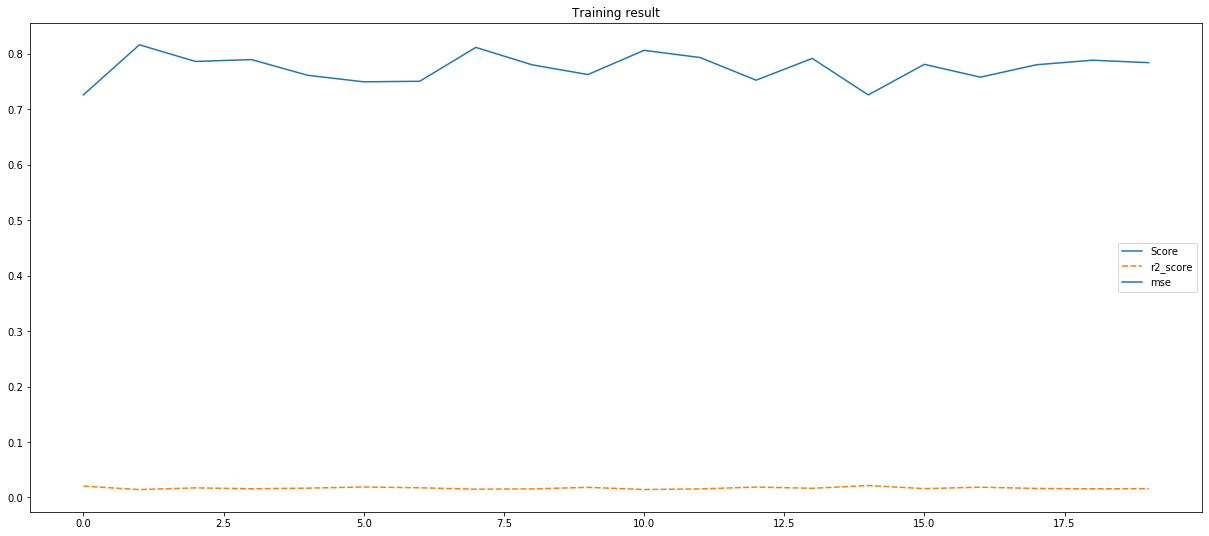

In [52]:
plt.figure(figsize=(21,9))
plt.title('Training result')
sns.lineplot(data=result[["score", "mse"]])
plt.legend(["Score", "r2_score", "mse"])

([<matplotlib.axis.XTick at 0x2ad480c1630>,
 <a list of 130 Text xticklabel objects>)

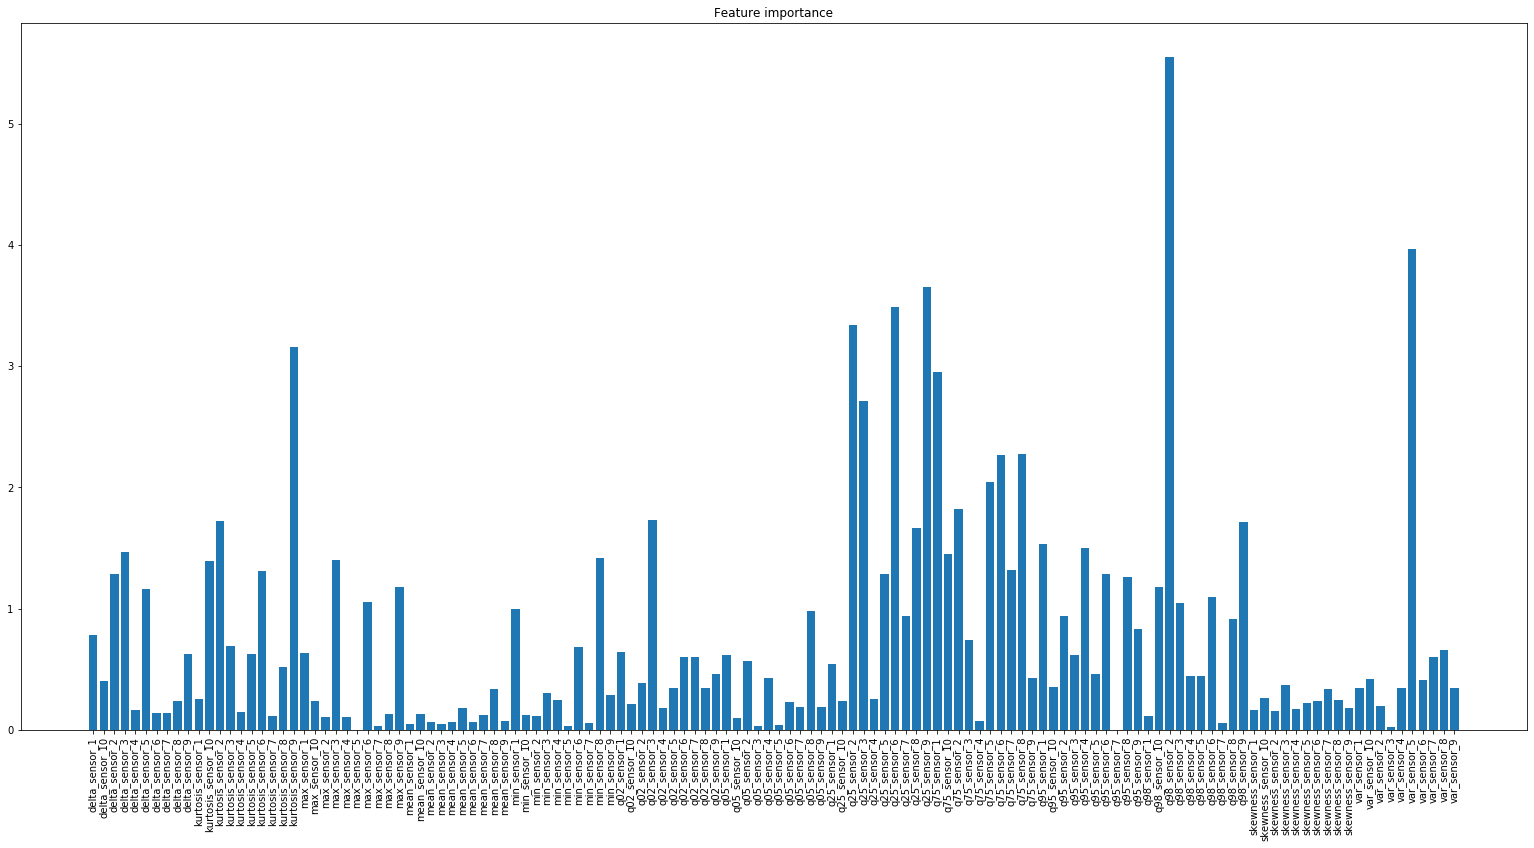

In [53]:
plt.figure(figsize=(27,13))
plt.title('Feature importance')
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), \
           final_df.drop(['segment_id', 'score_to_predict'], axis=1).columns, rotation=90)

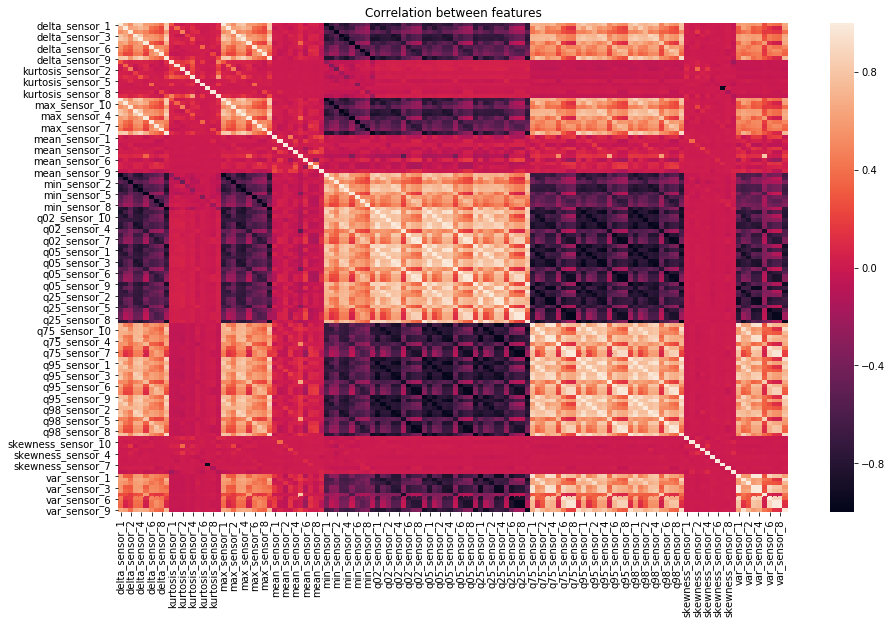

In [54]:
corr = final_df.drop(['segment_id', 'score_to_predict'], axis=1).corr()
plt.figure(figsize=(15,9))
plt.title('Correlation between features')
sns.heatmap(corr)

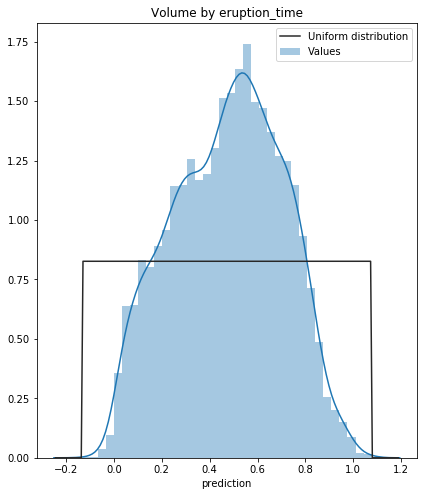

In [55]:
scaled_df['prediction'] = model.predict(scaled_df.drop(['segment_id', 'score_to_predict'], axis=1))
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title("Volume by eruption_time")
sns.distplot(scaled_df.prediction, fit=uniform)
plt.legend(["Uniform distribution", "Values"])
scaled_df.prediction = min_max_scaler.inverse_transform(scaled_df['prediction'].values.reshape(-1, 1))

In [56]:
sub_df = scaled_df.loc[train_df_rows:]
sub_df = sub_df[['segment_id', 'prediction']].rename(columns={'prediction': 'time_to_eruption'})
sub_df = sub_df.astype({'segment_id': np.int64, 'time_to_eruption': np.int64})
sub_df = sub_df.reset_index(drop=True)
sub_df.head()
sub_df.to_csv('my_submission.csv', index=False)

In [57]:
if not os.path.exists('my_submission.csv'):
    raise FileNotFoundError('Failed')
else: 
    print(submit(os.path.join(PROJECT_PATH, 'my_submission.csv'), 'my first submission -> Reference'))

b'Successfully submitted to INGV - Volcanic Eruption Prediction'
